# Scoring Model - Prédiction de solvabilité bancaire

* Contexte : 
 - L’entreprise "Prêt à Penser" souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé.   
 - Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.)-
 - Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.  
 

* Mission
    - Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
    - Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
    
* Spécifications du dashboard interactif : 
    - Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
    - Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
    - Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.


* Livrables :
    - Le dashboard interactif répondant aux spécifications ci-dessus et l’API de prédiction du score, déployées chacunes sur le cloud.
    - Un dossier sur un outil de versioning de code contenant :
        - Le code de la modélisation (du prétraitement à la prédiction)
        - Le code générant le dashboard
        - Le code permettant de déployer le modèle sous forme d'API
    - Une note méthodologique décrivant :
        - La méthodologie d'entraînement du modèle (2 pages maximum)
        - La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation (1 page maximum)
        - L’interprétabilité globale et locale du modèle (1 page maximum)
        - Les limites et les améliorations possibles (1 page maximum)
    - Un support de présentation pour la soutenance, détaillant le travail réalisé.

# Sommaire

**<a href="#C1"> Préparation de l'environnement <a>**
 - <a href="#C11">Importation des librairies</a>
 - <a href="#C12">Importation des données</a>
    - <a href="#C121">Visualisation des données</a>
    - <a href="#C122">Visualisation du MCD </a>
    - <a href="#C123">Dataset description</a>
***    
    
**<a href="#C2"> Feature Enginering <a>**
 - <a href="#C21">Application du Kernel Kaggle</a>
 - <a href="#C22">Pré processing des variables </a>
 - <a href="#C23">Split des données & Resampling</a>
    
***
**<a href="#C3"> Scoring Model <a>**
 - <a href="#C31">Création du score métier</a>
 - <a href="#C32">Comparaison de model </a>
    - <a href="#C321">KMeans </a>
    - <a href="#C322">Random Forest Classifier </a>
    - <a href="#C323">LightGBM </a>
    - <a href="#C324">Résumé </a>
 - <a href="#C33">Features importances</a>
 - <a href="#C34">Entrainement du modèle final</a>

# <a name="C1"> Préparation de l'environnement </a>
## <a name="C11">Importation des librairies</a>

In [1]:
import pandas as pd
import numpy as np

from PIL import Image
import requests
from io import BytesIO

In [42]:
#librairies 
import gc
import time
from contextlib import contextmanager
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re

In [41]:
import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline

0.9.1


## <a name="C12">Importation des données</a>

In [2]:
#Chemin d'accèes : 
Path_app_test = "/Users/adpro/Desktop/OCR_DS/DS_P7/Data/application_test.csv"
Path_app_train = "/Users/adpro/Desktop/OCR_DS/DS_P7/Data/application_train.csv"
Path_bureau_balance = "/Users/adpro/Desktop/OCR_DS/DS_P7/Data/bureau_balance.csv"
Path_bureau = "/Users/adpro/Desktop/OCR_DS/DS_P7/Data/bureau.csv"
Path_creditcard_balance = "/Users/adpro/Desktop/OCR_DS/DS_P7/Data/credit_card_balance.csv"
Path_homecredit = "/Users/adpro/Desktop/OCR_DS/DS_P7/Data/HomeCredit_columns_description.csv"
Path_instpayments = "/Users/adpro/Desktop/OCR_DS/DS_P7/Data/installments_payments.csv"
Path_poscash = "/Users/adpro/Desktop/OCR_DS/DS_P7/Data/POS_CASH_balance.csv"
Path_previous_app = "/Users/adpro/Desktop/OCR_DS/DS_P7/Data/previous_application.csv"
Path_sample = "/Users/adpro/Desktop/OCR_DS/DS_P7/Data/sample_submission.csv"

In [3]:
#Importations : 
df_apptest = pd.read_csv(Path_app_test, sep=",")  
df_apptrain = pd.read_csv(Path_app_train, sep=",")
df_bureaubal = pd.read_csv(Path_bureau_balance, sep=",")
df_bureau = pd.read_csv(Path_bureau, sep=",") 
df_creditcard = pd.read_csv(Path_creditcard_balance, sep=",") 
df_homecredit = pd.read_csv(Path_homecredit,encoding ="Windows-1252") 
df_payments = pd.read_csv(Path_instpayments, sep=",") 
df_poscash = pd.read_csv(Path_poscash, sep=",") 
df_prevapp = pd.read_csv(Path_previous_app, sep=",") 
df_sample = pd.read_csv(Path_sample, sep=",") 

### <a name="C121">Visualisation des donées</a>

In [4]:
#liste des data frames : 
dfs = [df_apptest,df_apptrain,df_bureaubal,df_bureau,df_creditcard,df_homecredit,
       df_payments,df_poscash,df_prevapp,df_sample]

#fonction pour avoir le nom des data frame :
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

#liste des noms des df
dfs_names = []
for df in dfs: 
    dfs_names.append(get_df_name(df))

In [5]:
#shape des différentes df : 
for df in dfs:
    print(get_df_name(df))
    print(df.shape)

df_apptest
(48744, 121)
df_apptrain
(307511, 122)
df_bureaubal
(27299925, 3)
df_bureau
(1716428, 17)
df_creditcard
(3840312, 23)
df_homecredit
(219, 5)
df_payments
(13605401, 8)
df_poscash
(10001358, 8)
df_prevapp
(1670214, 37)
df_sample
(48744, 2)


In [6]:
#type des variables de chaques df 
for df in dfs : 
    print(get_df_name(df))
    print(df.dtypes)
    print("-"*90)

df_apptest
SK_ID_CURR                      int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 121, dtype: object
------------------------------------------------------------------------------------------
df_apptrain
SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: obj

In [8]:
df_apptest.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_apptest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [10]:
df_apptrain.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_apptrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [12]:
df_bureaubal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [13]:
df_bureaubal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [14]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [15]:
df_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [16]:
df_creditcard.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [17]:
df_creditcard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [18]:
df_homecredit.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [19]:
df_homecredit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


In [20]:
df_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [21]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [22]:
df_poscash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [23]:
df_poscash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [24]:
df_prevapp.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_prevapp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [26]:
df_sample.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


In [27]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


In [28]:
#nombre de valeurs manquantes par df : 
for df in dfs : 
    print(get_df_name(df))
    print(df.isna().sum())
    print("-"*90)

df_apptest
SK_ID_CURR                       0
NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
                              ... 
AMT_REQ_CREDIT_BUREAU_DAY     6049
AMT_REQ_CREDIT_BUREAU_WEEK    6049
AMT_REQ_CREDIT_BUREAU_MON     6049
AMT_REQ_CREDIT_BUREAU_QRT     6049
AMT_REQ_CREDIT_BUREAU_YEAR    6049
Length: 121, dtype: int64
------------------------------------------------------------------------------------------
df_apptrain
SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64
-----------------------------------------------------

### <a name="C122">Visualisation du MCD</a>

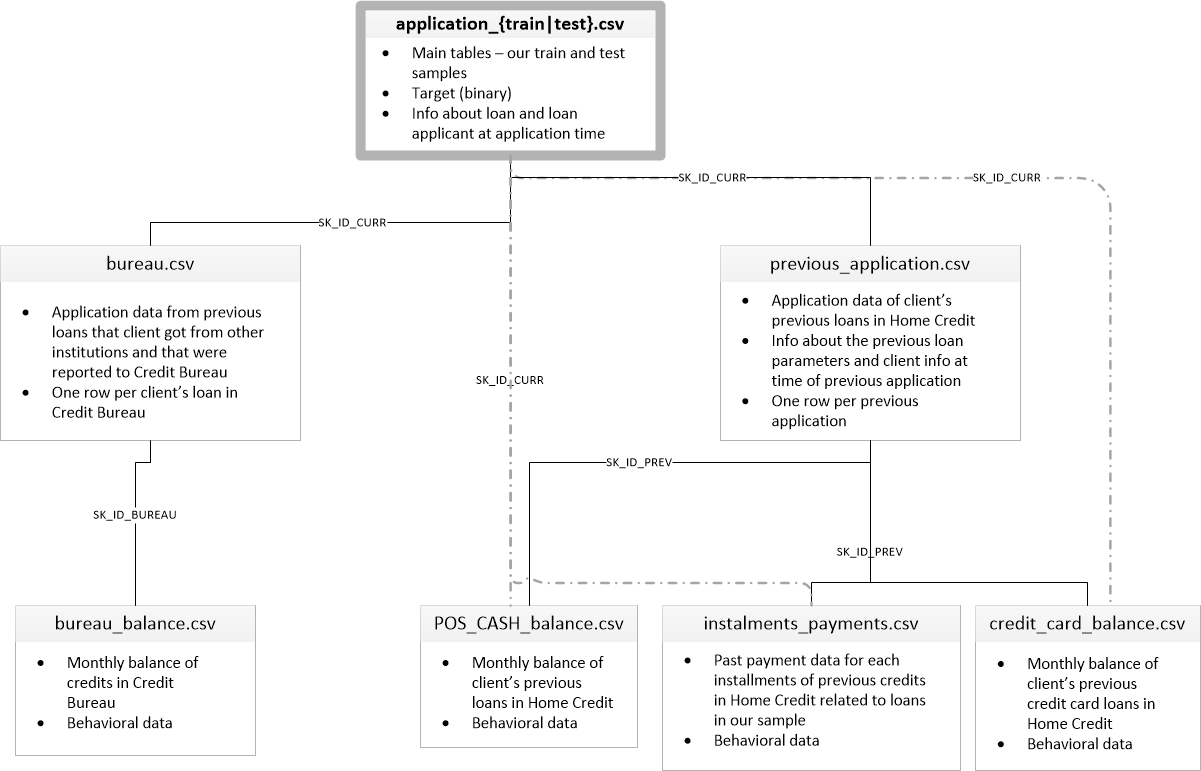

In [29]:
response = requests.get("https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png")
img = Image.open(BytesIO(response.content))
img

### <a name="C123">Dataset Description</a>
* application_{train|test}.csv : 
    - This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET). Static data for all applications. 
    - One row represents one loan in our data sample.

* bureau.csv : 
    - All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). 
    - For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

* bureau_balance.csv : 
    - Monthly balances of previous credits in Credit Bureau. 
    - This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
    
* POS_CASH_balance.csv : 
    - Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

* credit_card_balance.csv : 
    - Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

* previous_application.csv : 
    - All previous applications for Home Credit loans of clients who have loans in our sample.
    - There is one row for each previous application related to loans in our data sample.

* installments_payments.csv : 
    - Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    - There is a) one row for every payment that was made plus b) one row each for missed payment.
    - One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

* HomeCredit_columns_description.csv : 
    - This file contains descriptions for the columns in the various data files.

# <a name="C2">Feature enginering</a>

## <a name="C21">Application du Kernel Kaggle</a>

* Application d'un kernel Kaggle adapté : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script
* Entrainement sur un échantillon de données


In [269]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)



@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

#on retire la partie test 
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(Path_app_train, nrows= num_rows)
    print("Train samples: {}".format(len(df)))
    #df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    #del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(Path_bureau, nrows = num_rows)
    bb = pd.read_csv(Path_bureau_balance, nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(Path_previous_app, nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(Path_poscash, nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(Path_instpayments, nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(Path_creditcard_balance, nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg    

* Application du kernel sur un sample des données

In [270]:
#Application du kernel de featuring 
#puis sauvegarde d'un echantillon des données pour paramétrer le modèle de classification

def main(debug = False,num_rows_input=None):
    num_rows = 30000 if debug else None
    if num_rows_input != None : 
        num_rows = num_rows_input
    
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        df.to_csv("/Users/adpro/Desktop/OCR_DS/DS_P7/Data/df_samp30k.csv")

In [271]:
#application des fonction 
if __name__ == "__main__":
    with timer("Full model run"):
        main(True,30000)

Train samples: 30000
Bureau df shape: (6076, 111)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (27837, 246)
Process previous_applications - done in 1s
Pos-cash balance df shape: (27135, 15)
Process POS-CASH balance - done in 1s
Installments payments df shape: (22446, 26)
Process installments payments - done in 1s
Credit card balance df shape: (24459, 131)
Process credit card balance - done in 11s
Full model run - done in 15s


## <a name="C22">Pré-processing - des variables</a>

In [31]:
#importation de la df echantillon : 
df_samp30k = pd.read_csv("/Users/adpro/Desktop/OCR_DS/DS_P7/Data/df_samp30k.csv", sep=",")

* adaptation du noms des colonnes pour les algorithmes et élimination des colonnes vides

In [32]:
# Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df_samp30k.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
df_samp30k = df_samp30k.rename(columns=new_names)
df_samp30k.head(5)

,Unnamed0,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_samp30k = df_samp30k.drop(["Unnamed0"],1)

In [34]:
train_df = df_samp30k[df_samp30k['TARGET'].notnull()]
test_df = df_samp30k[df_samp30k['TARGET'].isnull()]
print(train_df.shape)
print(test_df.shape)

(30000, 774)
(0, 774)


In [35]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
df_feats = train_df[feats]

* Elimination des colonnes vides

In [36]:
y=train_df['TARGET']
X=df_feats
X.isnull().sum().sum()

15809854

In [37]:
#Complétion des valeurs manquantes
X = X.fillna(X.median())
X.isnull().sum().sum()

540000

In [38]:
#affichage des variables qui on encore des valeurs manquantes
nan_cols = [i for i in X.columns if X[i].isnull().any()]
X[nan_cols].isnull().sum()

BURO_MONTHS_BALANCE_MIN_MIN        30000
BURO_MONTHS_BALANCE_MAX_MAX        30000
BURO_MONTHS_BALANCE_SIZE_MEAN      30000
BURO_STATUS_0_MEAN_MEAN            30000
BURO_STATUS_1_MEAN_MEAN            30000
BURO_STATUS_2_MEAN_MEAN            30000
BURO_STATUS_3_MEAN_MEAN            30000
BURO_STATUS_4_MEAN_MEAN            30000
BURO_STATUS_5_MEAN_MEAN            30000
BURO_STATUS_C_MEAN_MEAN            30000
BURO_STATUS_X_MEAN_MEAN            30000
BURO_STATUS_nan_MEAN_MEAN          30000
ACTIVE_MONTHS_BALANCE_MIN_MIN      30000
ACTIVE_MONTHS_BALANCE_MAX_MAX      30000
ACTIVE_MONTHS_BALANCE_SIZE_MEAN    30000
CLOSED_MONTHS_BALANCE_MIN_MIN      30000
CLOSED_MONTHS_BALANCE_MAX_MAX      30000
CLOSED_MONTHS_BALANCE_SIZE_MEAN    30000
dtype: int64

In [39]:
X = X.dropna(how='all',axis=1)
X.isnull().sum().sum()

0

## <a name="C23">Split des données & Resampling</a>

In [43]:
#les données sont umbalanced : 
print("Label 1 avant SMOTE : {}".format(sum(y==1)))
print("Label 0 avant SMOTE : {}".format(sum(y==0)))

Label 1 avant SMOTE : 2403
Label 0 avant SMOTE : 27597


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = pd.DataFrame(X_train.values, columns=X.columns)
X_test  = pd.DataFrame(X_test.values, columns=X.columns)
y_train = y_train.values
y_test  = y_test.values

In [45]:
#les données sont umbalanced : 
print("Label 1 train avant SMOTE : {}".format(sum(y_train==1)))
print("Label 0 train avant SMOTE : {}".format(sum(y_train==0)))
print("Label 1 test avant SMOTE : {}".format(sum(y_test==1)))
print("Label 0 test avant SMOTE : {}".format(sum(y_test==0)))

Label 1 train avant SMOTE : 1922
Label 0 train avant SMOTE : 22078
Label 1 test avant SMOTE : 481
Label 0 test avant SMOTE : 5519


In [46]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Label 1 après SMOTE : {}".format(sum(y_res==1)))
print("Label 0 après SMOTE : {}".format(sum(y_res==0)))

Label 1 après SMOTE : 22078
Label 0 après SMOTE : 22078


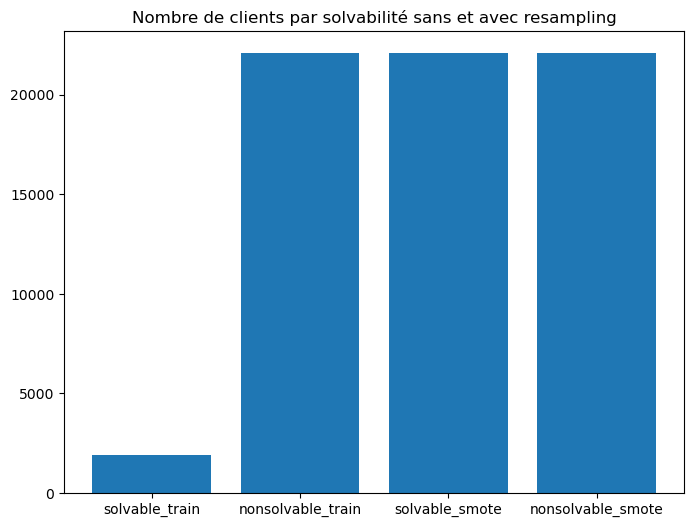

In [51]:
#graphique représentant le nombre de clients selon leur solvablité avec ou sans resampling 
height = [sum(y_train==1),sum(y_train==0), sum(y_res==1),sum(y_res==0)]
bars = ('solvable_train', 'nonsolvable_train', 'solvable_smote', 'nonsolvable_smote')
y_pos = np.arange(len(bars))
plt.figure(figsize=(8, 6))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.title("Nombre de clients par solvabilité sans et avec resampling")
plt.show()

# <a name="C3"> Scoring Model </a>
## <a name="C31"> Création du score métier </a>

In [717]:
import math
from math import *

#Fonction indicateteur risque : 
def indic_r(y_test, y_pred):
    """
    fonction visant à créer un score métier retournant la qualité du modèle selon le nombre : 
    - du manque à gagner : faux négatifs
    - des mauvais investissement : faux positifs
    nous allons donner plus de poids aux fp qu'aux fn.
    Le score varie entre -1 et 1. 
    """

    fn_value=5
    fp_value=15
    tp_value=0.1
    tn_value=3
    
    #Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    #True Negatifs : Clients non solvables identifiés comme tels
    tn = cm[0, 0]
    #False Negatifs : Clients identifiés comme non solvables alors qu'ils le sont
    fn = cm[1, 0]
    #False Positifs : Clients identifiés comme solvables alors qu'ils ne le sont pas
    fp = cm[0, 1]
    #True Positifs : Clients solvables identifiés comme tels
    tp = cm[1, 1]
    
    #nombre de cas totaux ponderé : 
    tot_sum = tn*tn_value+fn*fn_value+tp*tp_value+fp*fp_value

    #sommes pondérés cas mal identifés 
    erro_sum  = fp*fp_value + fn*fn_value
    
    #somme pondéré des cas bien identifiés : 
    corr_sum = tp*tp_value + tn*tn_value 

    #indice de risque : 
    risque_score = 1- ((corr_sum - erro_sum) / tot_sum)
    
    
    return risque_score

## <a name="C32"> Comparaison de model </a>
### <a name="C321"> KMeans </a>

In [404]:
from sklearn import cluster
from sklearn.cluster import KMeans

In [450]:
#imposition d'une solution à 2 clusters
km = KMeans(n_clusters = 2, random_state = 42)

In [451]:
%%time
km.fit(X)
km_y_pred = km.predict(X)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.3 µs


In [629]:
km_time = 1

In [454]:
from sklearn.metrics import silhouette_samples, silhouette_score
# Score de silhouette
silhouette_score = silhouette_score(X, km.predict(X))

# lets see what that score it
print(silhouette_score)

0.9994447530027483


In [416]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

<AxesSubplot:>

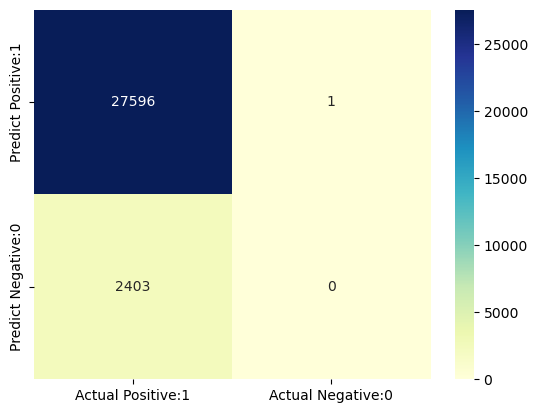

In [672]:
cm_km = confusion_matrix(y, km_y_pred)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm_km,
                         columns=['Actual Positive:1', 'Actual Negative:0'], 
                         index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [718]:
risque_km = indic_r(y, km_y_pred)
risque_km

0.25374928810985253

### <a name="C322"> Random Forest Classifier </a>

In [465]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

* sans smote

In [544]:
%%time
rfc = RandomForestClassifier()
param_grid = {'n_estimators': [1000,2000],
              'max_depth' : [15,25,30],
              'min_samples_leaf' : [0.01,0.05]
             }
model = GridSearchCV(rfc,param_grid,cv=3)

rfc_tr = model.fit(X_train,y_train)             

CPU times: user 17min 26s, sys: 5.94 s, total: 17min 32s
Wall time: 17min 35s


In [549]:
rfc_tr_time = 1055

In [545]:
cv_score_rfctr = rfc_tr.best_score_
test_score_gtr = rfc_tr.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_rfctr}\nTest score: {test_score_gtr}')
print(rfc_tr.best_params_)

Cross-validation score: 0.9199166666666668
Test score: 0.9198333333333333
{'max_depth': 15, 'min_samples_leaf': 0.01, 'n_estimators': 1000}


In [565]:
# Faire des nouvelles prediction
y_pred_rfctr = rfc_tr.predict(X_test)
auc_rfctr = round(roc_auc_score(y_test, y_pred_rfctr),4)
print(f'ROC_AUC: {auc_rfctr}')

ROC_AUC: 0.5


<AxesSubplot:>

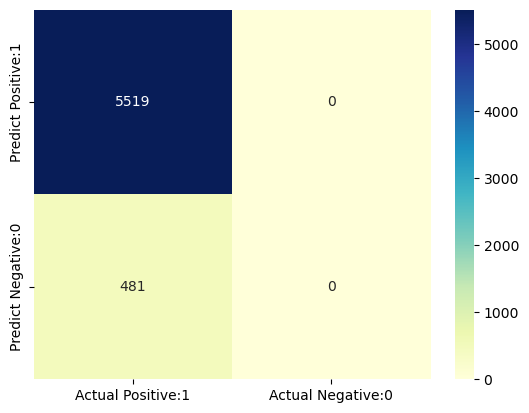

In [566]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_rfctr)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                             index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [567]:
# Evaluation de modele
print(f"le rapport de classificatiob de l'algorithme EEC est : \n")
print(classification_report(y_test,y_pred_rfctr))

le rapport de classificatiob de l'algorithme EEC est : 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      5519
           1       0.00      0.00      0.00       481

    accuracy                           0.92      6000
   macro avg       0.46      0.50      0.48      6000
weighted avg       0.85      0.92      0.88      6000



In [719]:
# Calculation of F-beta Score
from sklearn.metrics import fbeta_score

f2_rfctr_train = fbeta_score(y_train, rfc_tr.predict(X_train), average='macro', beta=2)
print(f"fbeta_score Train =  {f2_rfctr_train}")

f2_rfctr_test = fbeta_score(y_test, rfc_tr.predict(X_test), average='macro', beta=2)
print(f"fbeta_score Test =  {f2_rfctr_test}")

risque_rfctr = indic_r(y_test,y_pred_rfctr)
print(f"score de risque = {risque_rfctr}")

fbeta_score Train =  0.49144347888026213
fbeta_score Test =  0.4914339649522724
score de risque = 0.25366522518721657


* smote

In [557]:
%%time
rfc = RandomForestClassifier()
param_grid = {'n_estimators': [1000,2000],
              'max_depth' : [15,25],
              'min_samples_leaf' : [0.01,0.05]
             }
model = GridSearchCV(rfc,param_grid,cv=3)

rfc_res = model.fit(X_res,y_res)             

CPU times: user 26min 2s, sys: 5.77 s, total: 26min 8s
Wall time: 29min 42s


In [628]:
rfc_res_time = 1782

In [558]:
cv_score_rfcres = rfc_res.best_score_
test_score_rfcres = rfc_res.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_rfcres}\nTest score: {test_score_rfcres}')
print(rfc_res.best_params_)

Cross-validation score: 0.9293422689844203
Test score: 0.9066666666666666
{'max_depth': 15, 'min_samples_leaf': 0.01, 'n_estimators': 1000}


In [569]:
# Faire des nouvelles prediction
y_pred_rfcres = rfc_res.predict(X_test)
auc_rfcres = round(roc_auc_score(y_test, y_pred_rfcres),4)
print(f'ROC_AUC: {auc_rfcres}')

ROC_AUC: 0.5384


<AxesSubplot:>

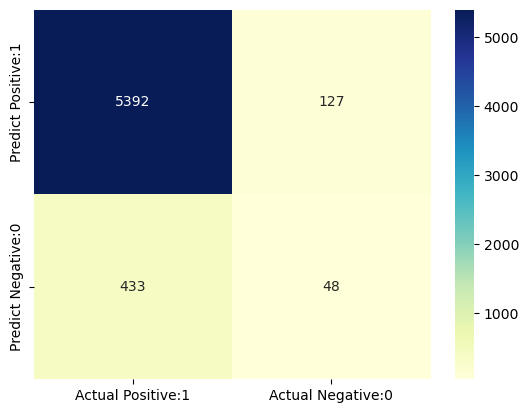

In [570]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_rfcres)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                             index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [571]:
# Evaluation de modele
print(f"le rapport de classificatiob de l'algorithme EEC est : \n")
print(classification_report(y_test,y_pred_rfcres))

le rapport de classificatiob de l'algorithme EEC est : 

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5519
           1       0.27      0.10      0.15       481

    accuracy                           0.91      6000
   macro avg       0.60      0.54      0.55      6000
weighted avg       0.87      0.91      0.89      6000



In [720]:
# Calculation of F-beta Score
from sklearn.metrics import fbeta_score

f2_rfcres_train = fbeta_score(y_train, rfc_res.predict(X_train), average='macro', beta=2)
print(f"fbeta_score Train =  {f2_rfcres_train}")

f2_rfcres_test = fbeta_score(y_test, rfc_res.predict(X_test), average='macro', beta=2)
print(f"fbeta_score Test =  {f2_rfcres_test}")

risque_rfres = indic_r(y_test,y_pred_rfcres)
print(f"score de risque = {risque_rfres}")

fbeta_score Train =  0.5271541802642621
fbeta_score Test =  0.5403068861233806
score de risque = 0.40195942876330815


### <a name="C323"> LightGBM </a>

* sans smote

In [586]:
%%time
clf = LGBMClassifier(is_unbalance=True)

param_grid = {'n_estimators': [1000,2000],
              'max_depth' : [5,15,25],
              'subsample': [0.2,0.5],
              'num_leaves': [25,50]
             }

model = GridSearchCV(clf,param_grid,cv=3)

lgbm_gtr = model.fit(X_train,y_train)

CPU times: user 3h 51min 4s, sys: 16min 7s, total: 4h 7min 11s
Wall time: 32min 48s


In [627]:
gtr_time = 1968

In [602]:
cv_score_gtr = lgbm_gtr.best_score_
test_score_gtr = lgbm_gtr.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_gtr}\nTest score: {test_score_gtr}')
print(lgbm_gtr.best_params_)

Cross-validation score: 0.9184166666666665
Test score: 0.9166666666666666
{'max_depth': 15, 'n_estimators': 2000, 'num_leaves': 50, 'subsample': 0.2}


In [616]:
# Faire des nouvelles prediction
y_pred_gtr = lgbm_gtr.predict(X_test)
auc_rfgtr = round(roc_auc_score(y_test, y_pred_gtr),4)
print(f'ROC_AUC: {auc_rfgtr}')

ROC_AUC: 0.5173


<AxesSubplot:>

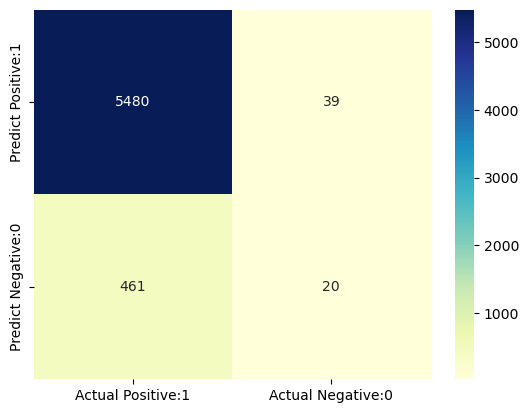

In [617]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_gtr)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                             index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [618]:
# Evaluation de modele
print(f"le rapport de classificatiob de l'algorithme EEC est : \n")
print(classification_report(y_test,y_pred_gtr))

le rapport de classificatiob de l'algorithme EEC est : 

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5519
           1       0.34      0.04      0.07       481

    accuracy                           0.92      6000
   macro avg       0.63      0.52      0.52      6000
weighted avg       0.88      0.92      0.89      6000



In [721]:
# Calculation of F-beta Score
from sklearn.metrics import fbeta_score

f2_gtr_train = fbeta_score(y_train, lgbm_gtr.predict(X_train), average='macro', beta=2)
print(f"fbeta_score Train =  {f2_gtr_train}")

f2_gtr_test = fbeta_score(y_test, lgbm_gtr.predict(X_test), average='macro', beta=2)
print(f"fbeta_score Test =  {f2_gtr_test}")

risque_gtr = indic_r(y_test,y_pred)
print(f"score de risque = {risque_gtr}")

fbeta_score Train =  1.0
fbeta_score Test =  0.5142031499461883
score de risque = 0.40195942876330815


* Smote

In [620]:
%%time
clf = LGBMClassifier(is_unbalance=True)

param_grid = {'n_estimators': [1000,2000],
              'max_depth' : [5,15,25],
              'subsample': [0.2,0.5],
              'num_leaves': [25,50]
             }

model = GridSearchCV(clf,param_grid,cv=3)

lgbm_gres = model.fit(X_res,y_res)

CPU times: user 4h 51min, sys: 19min 11s, total: 5h 10min 12s
Wall time: 34min 29s


In [626]:
gres_time = 2069

In [621]:
cv_score_gres = lgbm_gres.best_score_
test_score_gres = lgbm_gres.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_gres}\nTest score: {test_score_gres}')
print(lgbm2_gtr.best_params_)

Cross-validation score: 0.9530764131615598
Test score: 0.92
{'max_depth': 25, 'n_estimators': 1000, 'num_leaves': 50, 'subsample': 0.2}


In [622]:
# Faire des nouvelles prediction
y_predgres = lgbm2_gtr.predict(X_test)
auc_gres = round(roc_auc_score(y_test, y_predgres),4)
print(f'ROC_AUC: {auc_gres}')

ROC_AUC: 0.5124


<AxesSubplot:>

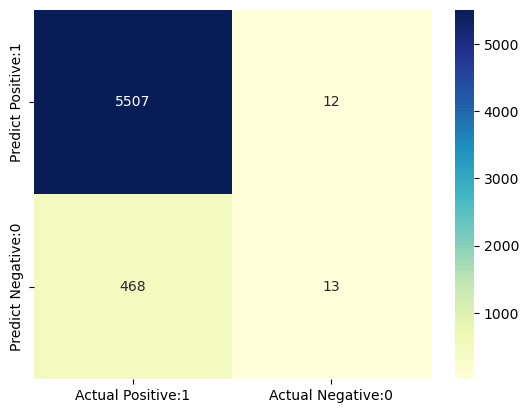

In [623]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_predgres)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                             index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [624]:
# Evaluation de modele
print(f"le rapport de classificatiob de l'algorithme EEC est : \n")
print(classification_report(y_test,y_predgres))

le rapport de classificatiob de l'algorithme EEC est : 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      5519
           1       0.52      0.03      0.05       481

    accuracy                           0.92      6000
   macro avg       0.72      0.51      0.50      6000
weighted avg       0.89      0.92      0.89      6000



In [722]:
# Calculation of F-beta Score
from sklearn.metrics import fbeta_score

f2_gres_train = fbeta_score(y_res, lgbm_gres.predict(X_res), average='macro', beta=2)
print(f"fbeta_score Train =  {f2_gres_train}")

f2_gres_test = fbeta_score(y_test, lgbm_gres.predict(X_test), average='macro', beta=2)
print(f"fbeta_score Test =  {f2_gres_test}")

risque_gres = indic_r(y_test,y_predgres)
print(f"score de risque = {risque_gres}")

fbeta_score Train =  1.0
fbeta_score Test =  0.507477684995769
score de risque = 0.26467391018942044


### <a name="C324"> Résumé </a>

In [724]:
model_rs = ("KMeans", "RandomForrest_train", "RandomForrest_smote", "Lgbm_train", "Lgbm_smote")
run_times = (km_time, rfc_tr_time, rfc_res_time, gtr_time, gres_time)
auc_km = 0
f2_km = 0
auc_resume = (auc_km, auc_rfctr, auc_rfcres, auc_gtr,auc_gres)
fbeta = (f2_km, f2_rfctr_test, f2_rfcres_test, f2_gtr_test,f2_gres_test)
risque_resume = (risque_km, risque_rfctr, risque_rfres, risque_gtr,risque_gres)


In [725]:
model_resume = pd.DataFrame(
    {'Model': model_rs,
     'Temps (s)': run_times,
     'AUC': auc_resume,
     'Fbeta2': fbeta,
     'Score de risque': risque_resume
    })
model_resume

,Model,Temps (s),AUC,Fbeta2,Score de risque
0,KMeans,1,0.0000,0.000000,0.253749
1,RandomForrest_train,1055,0.5000,0.491434,0.253665
2,RandomForrest_smote,1782,0.5384,0.540307,0.401959
3,Lgbm_train,1968,0.5065,0.514203,0.401959
4,Lgbm_smote,2069,0.5124,0.507478,0.264674


## <a name="C33"> Features importances </a>

* elimination des features sans variances

In [53]:
clf_gres = LGBMClassifier(application='binary',
                          is_unbalance=True,
                          metric='auc',
                           max_depth=25,
                           n_estimators=1000,
                           num_leaves=50,
                           subsample=0.2
                          )

model_prefilt = clf_gres.fit(X_res,y_res)

In [54]:
y_predm = model_prefilt.predict(X_test)

In [55]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
    features = []
    for i in range(20):
        features.append(X_res.columns[indices[i]]) #After RFECV selection > X_data created

    sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

    plt.show()
    

In [56]:
roc_auc = roc_auc_score(y_test, model_prefilt.predict_proba(X_test)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.691524


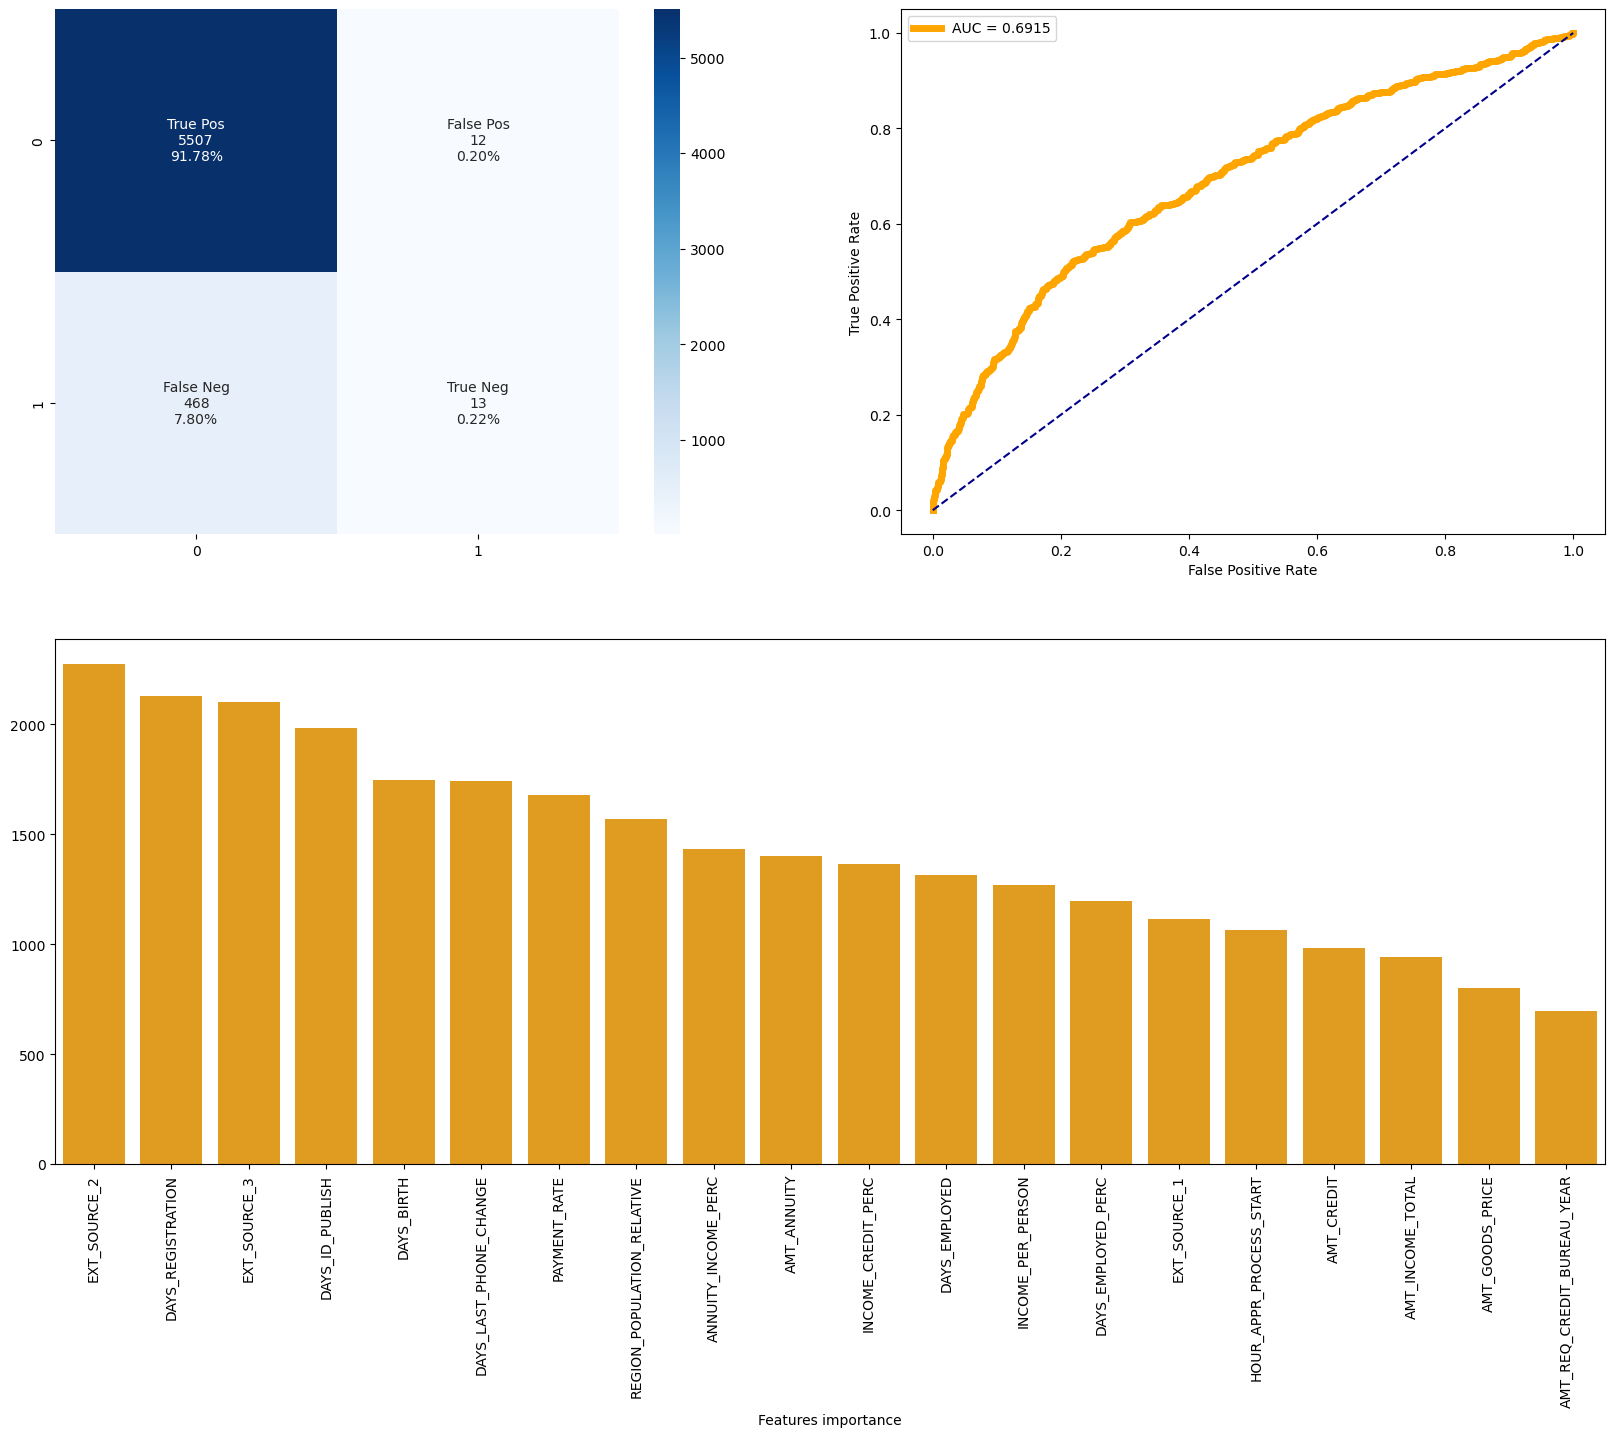

In [57]:
cf_matrix_roc_auc(model_prefilt, y_test, model_prefilt.predict(X_test),
                  model_prefilt.predict_proba(X_test)[:,1], feature_importances=True)

## <a name="C34"> Entrainement du modèle final </a>

In [58]:
#Test du modèle avec les 5 variables ayant le plus de poids : 
##Feature importance : 
feat8 = np.argsort(model_prefilt.feature_importances_)[::-1]
features8 = []
for i in range(8):
    features8.append(X_res.columns[feat8[i]])
print(features8)

['EXT_SOURCE_2', 'DAYS_REGISTRATION', 'EXT_SOURCE_3', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'PAYMENT_RATE', 'REGION_POPULATION_RELATIVE']


In [62]:
df_api = X[features8].copy()
df_api["Target"] = y

In [63]:
X_api = X[features8]
X_train_api = X_train[features8]
X_api_res = X_res[features8]
X_api_test = X_test[features8]
print(X.shape[1])
print(X_api.shape[1])
print(X_train_api.shape[1])
print(X_api_res.shape[1])
print(X_api_test.shape[1])

754
8
8
8
8


In [975]:
%%time
clf = LGBMClassifier(application='binary',is_unbalance=True, metric='auc')

param_grid = {'n_estimators': [2000,4000],
              'max_depth' : [15,30],
              'subsample': [0.1,0.3],
              'num_leaves': [35,40]
             }

model = GridSearchCV(clf,param_grid,cv=3)

lgbm_api = model.fit(X_api_res,y_res)

CPU times: user 2h 57min 38s, sys: 12min, total: 3h 9min 39s
Wall time: 20min 8s


In [976]:
cv_score_api = lgbm_api.best_score_
test_score_api = lgbm_api.score(X_api_test, y_test)
print(f'Cross-validation score: {cv_score_api}\nTest score: {test_score_api}')
print(lgbm_api.best_params_)

Cross-validation score: 0.9319465525676223
Test score: 0.9006666666666666
{'max_depth': 30, 'n_estimators': 4000, 'num_leaves': 35, 'subsample': 0.1}


In [977]:
# Faire des nouvelles prediction
y_predapi = lgbm_api.predict(X_api_test)
auc_api = round(roc_auc_score(y_test, y_predapi),4)
print(f'ROC_AUC: {auc_api}')

ROC_AUC: 0.5351


<AxesSubplot:>

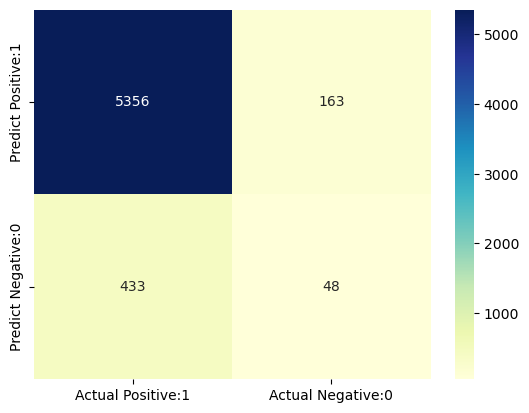

In [978]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_predapi)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                             index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [979]:
# Evaluation de modele
print(f"le rapport de classificatiob de l'algorithme EEC est : \n")
print(classification_report(y_test,y_predapi))

le rapport de classificatiob de l'algorithme EEC est : 

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5519
           1       0.23      0.10      0.14       481

    accuracy                           0.90      6000
   macro avg       0.58      0.54      0.54      6000
weighted avg       0.87      0.90      0.88      6000



In [980]:
f2_api_train = fbeta_score(y_res, lgbm_api.predict(X_api_res), average='macro', beta=2)
print(f"fbeta_score Train =  {f2_api_train}")

f2_api_test = fbeta_score(y_test, lgbm_api.predict(X_api_test), average='macro', beta=2)
print(f"fbeta_score Test =  {f2_api_test}")

risque_api = indic_r(y_test,y_predgres)
print(f"score de risque = {risque_api}")

fbeta_score Train =  1.0
fbeta_score Test =  0.5367372212377257
score de risque = 0.26467391018942044


In [832]:
clf_api = LGBMClassifier(application='binary',
                         is_unbalance=True,
                         metric='auc',
                         max_depth=30,
                         n_estimators=4000,
                         num_leaves=40,
                         subsample=0.1)

In [65]:
data_api = df_api.copy()
data_api["ID"] = df_samp30k["SK_ID_CURR"]

In [66]:
data_api.head()

,EXT_SOURCE_2,DAYS_REGISTRATION,EXT_SOURCE_3,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,PAYMENT_RATE,REGION_POPULATION_RELATIVE,Target,ID
0,0.262949,-3648.0,0.139376,-2120,-9461,-1134.0,0.060749,0.018801,1,100002
1,0.622246,-1186.0,0.535276,-291,-16765,-828.0,0.027598,0.003541,0,100003
2,0.555912,-4260.0,0.729567,-2531,-19046,-815.0,0.050000,0.010032,0,100004
3,0.650442,-9833.0,0.535276,-2437,-19005,-617.0,0.094941,0.008019,0,100006
4,0.322738,-4311.0,0.535276,-3458,-19932,-1106.0,0.042623,0.028663,0,100007


In [983]:
#exportation des données
data_api.to_csv("/Users/adpro/Desktop/lgbmAPI/data_api.csv",index=False)